<a href="https://colab.research.google.com/github/codebluecruz/Hyper-Parameter-Optimization-of-Decision-Tree-/blob/master/Operations_on_Final_WebMd_Dataset_with_LSTM_on_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [40]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
  for filename in filenames:
    print(os.path.join(dirname, filename))

In [41]:
# The Natural Language Toolkit, or more commonly NLTK, is a suite of libraries and programs for symbolic and 
# statistical natural language processing for English written in the Python programming language.
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
import re

#TQDM is a progress bar library with good support for nested loops and Jupyter/IPython notebooks.
from tqdm import tqdm

In [42]:
from keras.utils import to_categorical
import random
#set random seed for the session and also for tensorflow that runs in background for keras
import tensorflow
tensorflow.random.set_seed(123)

from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential



In [43]:
#git hub https://github.com/Stass88/lattelecom
train1 = pd.read_csv('WebMd_otherhalf.csv')
test1 = pd.read_csv('webmd_firsthalf.csv')

In [44]:
train1=train1.dropna()
test1=test1.dropna()

In [45]:
train = train1.drop(columns=['Age', 'Condition', 'Date', 'Drug', 'DrugId', 'EaseofUse', 'Effectiveness', 'Sex', 'Sides', 'UsefulCount'])
test = test1.drop(columns=['Age', 'Condition', 'Date', 'Drug', 'DrugId', 'EaseofUse', 'Effectiveness', 'Sex', 'Sides', 'UsefulCount'])
train.head()

,Reviews,Satisfaction
0,"I have success taking this drug, but have had ...",4
1,unfortunately this drug causes me migrane like...,2
2,"diagnosed with vertigo, this medication taken ...",4
3,Placed on this medicine after being taken off ...,1
4,i have only been on this drug for one week. I ...,1


In [46]:
def clean_sentences(df):
    reviews = []

    for sent in tqdm(df['Reviews']):
        
        #remove html content
        review_text = BeautifulSoup(sent).get_text()
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
    
        reviews.append(lemma_words)

    return(reviews)

In [50]:
#cleaned reviews for both train and test set retrieved


nltk.download('punkt') ## added for GoogleCollab
nltk.download('wordnet') ## added for GoogleCollab

train_sentences = clean_sentences(train)
test_sentences = clean_sentences(test)
print(len(train_sentences))
print(len(test_sentences))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


100%|██████████| 99988/99988 [01:19<00:00, 1263.43it/s]

262781
99988


In [51]:
target=train.Satisfaction.values
y_target=to_categorical(target)
num_classes=y_target.shape[1]

In [54]:
X_train,X_val,y_train,y_val=train_test_split(train_sentences,y_target,test_size=0.2)
# removed ,stratify=y_target from above statement in Google Collab

In [55]:
#It is needed for initializing tokenizer of keras and subsequent padding

unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
#length of the list of unique_words gives the no of unique words
print(len(list(unique_words)))
print(len_max)

100%|██████████| 210224/210224 [00:01<00:00, 185899.91it/s]

70403
534


In [56]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

#texts_to_sequences(texts)

    # Arguments- texts: list of texts to turn to sequences.
    #Return: list of sequences (one per text input).
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

#padding done to equalize the lengths of all input reviews. LSTM networks needs all inputs to be same length.
#Therefore reviews lesser than max length will be made equal using extra zeros at end. This is padding.

X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)

print(X_train.shape,X_val.shape,X_test.shape)

(210224, 534) (52557, 534) (99988, 534)


In [57]:
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_acc', patience = 2)
callback = [early_stopping]

In [58]:
#Model using Keras LSTM

#Multilayer Perceptron (MLP) for multi-class softmax classification:
#Let’s build what’s probably the most popular type of model in NLP at the moment: Long Short Term Memory network. 
#This architecture is specially designed to work on sequence data.
#It fits perfectly for many NLP tasks like tagging and text classification.
#It treats the text as a sequence rather than a bag of words or as ngrams.

#Here’s a possible model definition:

model=Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 534, 300)          21120900  
_________________________________________________________________
lstm_1 (LSTM)                (None, 534, 128)          219648    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 11)                1111      
Total params: 21,397,567
Trainable params: 21,397,567
Non-trainable params: 0
__________________________________________

In [61]:
#This is done for learning purpose only. One can play around with different hyper parameters combinations
#and try increase the accuracy even more. For example, a different learning rate, an extra dense layer 
# before output layer, etc. Cross validation could be used to evaluate the model and grid search 
# further to find unique combination of parameters that give maximum accuracy. This model has a validation

history=model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=3, batch_size=1024, verbose=1, callbacks=callback)

Train on 210224 samples, validate on 52557 samples
Epoch 1/3
210224/210224 [==============================] - 5818s 28ms/step - loss: 1.3958 - accuracy: 0.4346 - val_loss: 1.2167 - val_accuracy: 0.5099
Epoch 2/3


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


210224/210224 [==============================] - 5850s 28ms/step - loss: 1.1889 - accuracy: 0.5244 - val_loss: 1.1316 - val_accuracy: 0.5421
Epoch 3/3
210224/210224 [==============================] - 5814s 28ms/step - loss: 1.0898 - accuracy: 0.5605 - val_loss: 1.0974 - val_accuracy: 0.5584


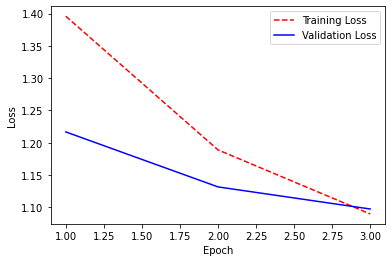

In [62]:
import matplotlib.pyplot as plt

# Create count of the number of epochs
epoch_count = range(1, len(history.history['loss']) + 1)

# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
#As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
#on accuracy and learning curve.
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [63]:
#make the predictions with trained model and submit the predictions.
y_pred=model.predict_classes(X_test)


In [74]:
y_pred

array([5, 5, 5, ..., 5, 1, 5])

<bound method NDFrame.head of               Age  ... UsefulCount
0      75 or over  ...           0
1           25-34  ...           1
2           65-74  ...           0
3      75 or over  ...           0
4           35-44  ...           1
...           ...  ...         ...
99995       45-54  ...           4
99996              ...           1
99997       55-64  ...           1
99998       19-24  ...           4
99999       45-54  ...           1

[99988 rows x 12 columns]>

In [77]:
sub_file = pd.read_csv('california_housing_test1.csv',sep=',')
sub_file=test1
sub_file.to_csv('california_housing_test3.csv',index=False)

In [80]:
sub_file = pd.read_csv('california_housing_test3.csv',sep=',')
sub_file.Satisfaction=y_pred
sub_file.to_csv('california_housing_test5.csv',index=False)